In [1]:
import sys
import os

# Step 1: Compute the path 3 levels up from the current working directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../" * 3))

# Step 2: Add it to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Step 3: Now you can import your module
import qf
import matplotlib.pyplot as plt
import numpy as np

/Users/PhilippSchmidt/miniforge3/envs/finrl-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
tickers = ["AAPL", "GOOGL", "MSFT", "AMZN", "TSLA", "NFLX"]
tickers = qf.DOWJONES

data = qf.get_data(tickers, 
                   start=qf.DEFAULT_TRAIN_START, 
                   end=qf.DEFAULT_TRAIN_END, 
                   indicators=["close"])
data.head(10)

Ticker,AAPL,AMZN,BA,CAT,CSCO,CVX,DIS,GS,HON,IBM,...,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,V,VZ,WMT
Price,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,...,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close
Date,,,,,,,,,,,,,,,,,,,,,
2005-06-30,1.106295,1.6545,46.607582,28.758160,12.561834,26.124001,20.194754,74.736816,22.265738,38.567436,...,17.279379,8.394026,0.204172,30.222679,11.983945,24.618349,41.358639,12.514242,11.324793,10.695188
2005-07-01,1.096977,1.6455,45.675434,28.945230,12.502586,26.614529,20.122574,75.242340,22.052990,38.811737,...,17.188944,8.336840,0.205089,30.308622,11.994126,24.661949,41.890121,12.514242,11.331347,10.712938
2005-07-05,1.141458,1.7040,46.198006,29.017654,12.390659,27.357332,20.082460,75.586639,21.858484,38.874115,...,17.376772,8.404691,0.208298,30.222679,11.991579,25.085436,42.223270,12.514242,11.446068,11.050218
2005-07-06,1.123726,1.7030,45.400032,28.755140,12.390659,26.703289,19.881966,75.857674,21.542389,39.404270,...,17.181995,8.295159,0.213876,30.079456,11.775261,24.960882,42.437431,12.514242,11.414559,10.957019
2005-07-07,1.130940,1.6980,46.028538,29.373682,12.403830,27.002275,19.609280,76.260582,21.524149,40.220348,...,17.147205,8.268021,0.212347,29.884642,11.793081,25.191313,42.429508,12.514242,11.378084,10.985862
2005-07-08,1.149572,1.7370,45.950851,29.781031,12.713262,26.796734,20.050388,77.396095,21.894943,41.218323,...,17.453281,8.359133,0.215022,30.342993,12.001760,24.929745,42.080475,12.514242,11.407931,11.072401
2005-07-11,1.145064,1.7795,45.880226,30.164223,12.864696,26.768692,20.194754,78.612144,21.815929,41.041573,...,17.592409,8.441522,0.218231,30.881561,12.167177,25.484003,41.588692,12.514242,11.374769,11.050218
2005-07-12,1.149271,1.8155,45.407089,29.859482,13.022703,26.866796,20.379211,78.560829,21.943581,41.602940,...,17.815016,8.435703,0.217009,30.904470,12.065385,25.527607,41.073086,12.514242,11.358185,11.114560


<Axes: title={'center': 'Close Price of All Tickers'}, xlabel='Date', ylabel='Price'>

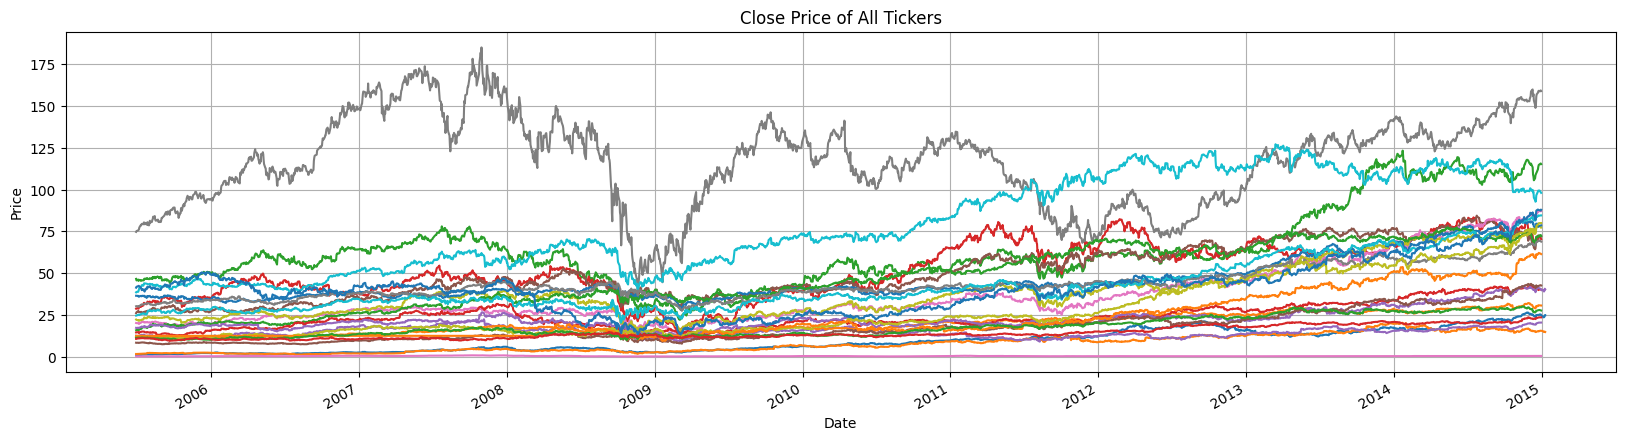

In [14]:
data.plot(figsize=(20, 5), title="Close Price of All Tickers", ylabel="Price", xlabel="Date", grid=True, legend=False)

In [15]:
# Calculate log returns
returns = data.pct_change().dropna()
log_returns = data.pct_change().apply(lambda x: np.log(1 + x)).dropna()

/var/folders/rd/w7px6r4d24ggh1dt8fbcc3x80000gn/T/ipykernel_40120/1787531787.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()
/var/folders/rd/w7px6r4d24ggh1dt8fbcc3x80000gn/T/ipykernel_40120/1787531787.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  log_returns = data.pct_change().apply(lambda x: np.log(1 + x)).dropna()


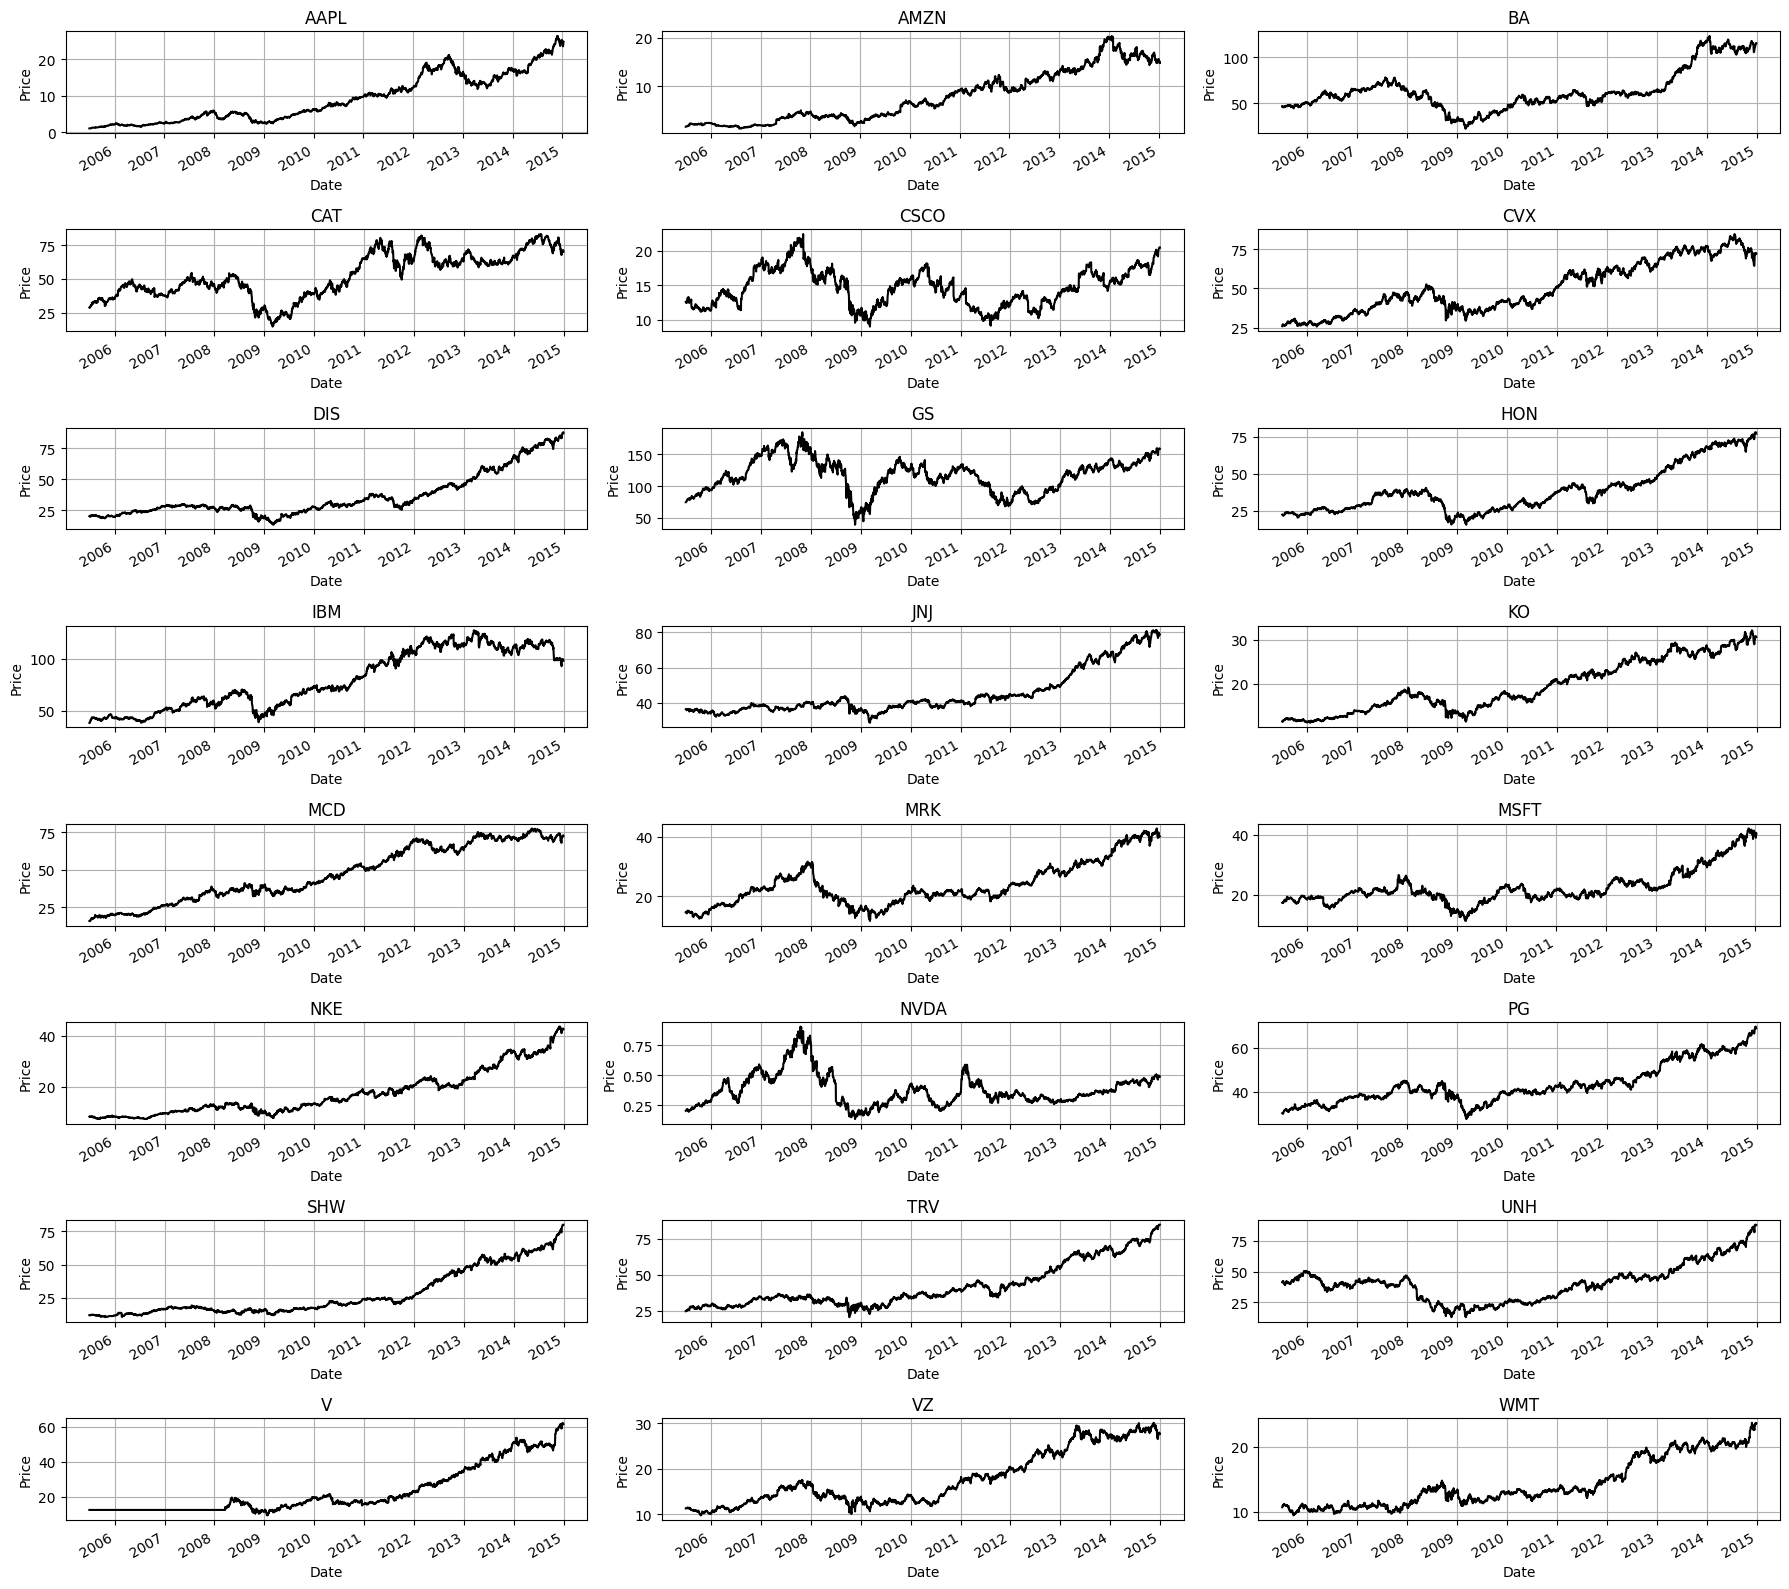

In [16]:
qf.plot_grid(data)

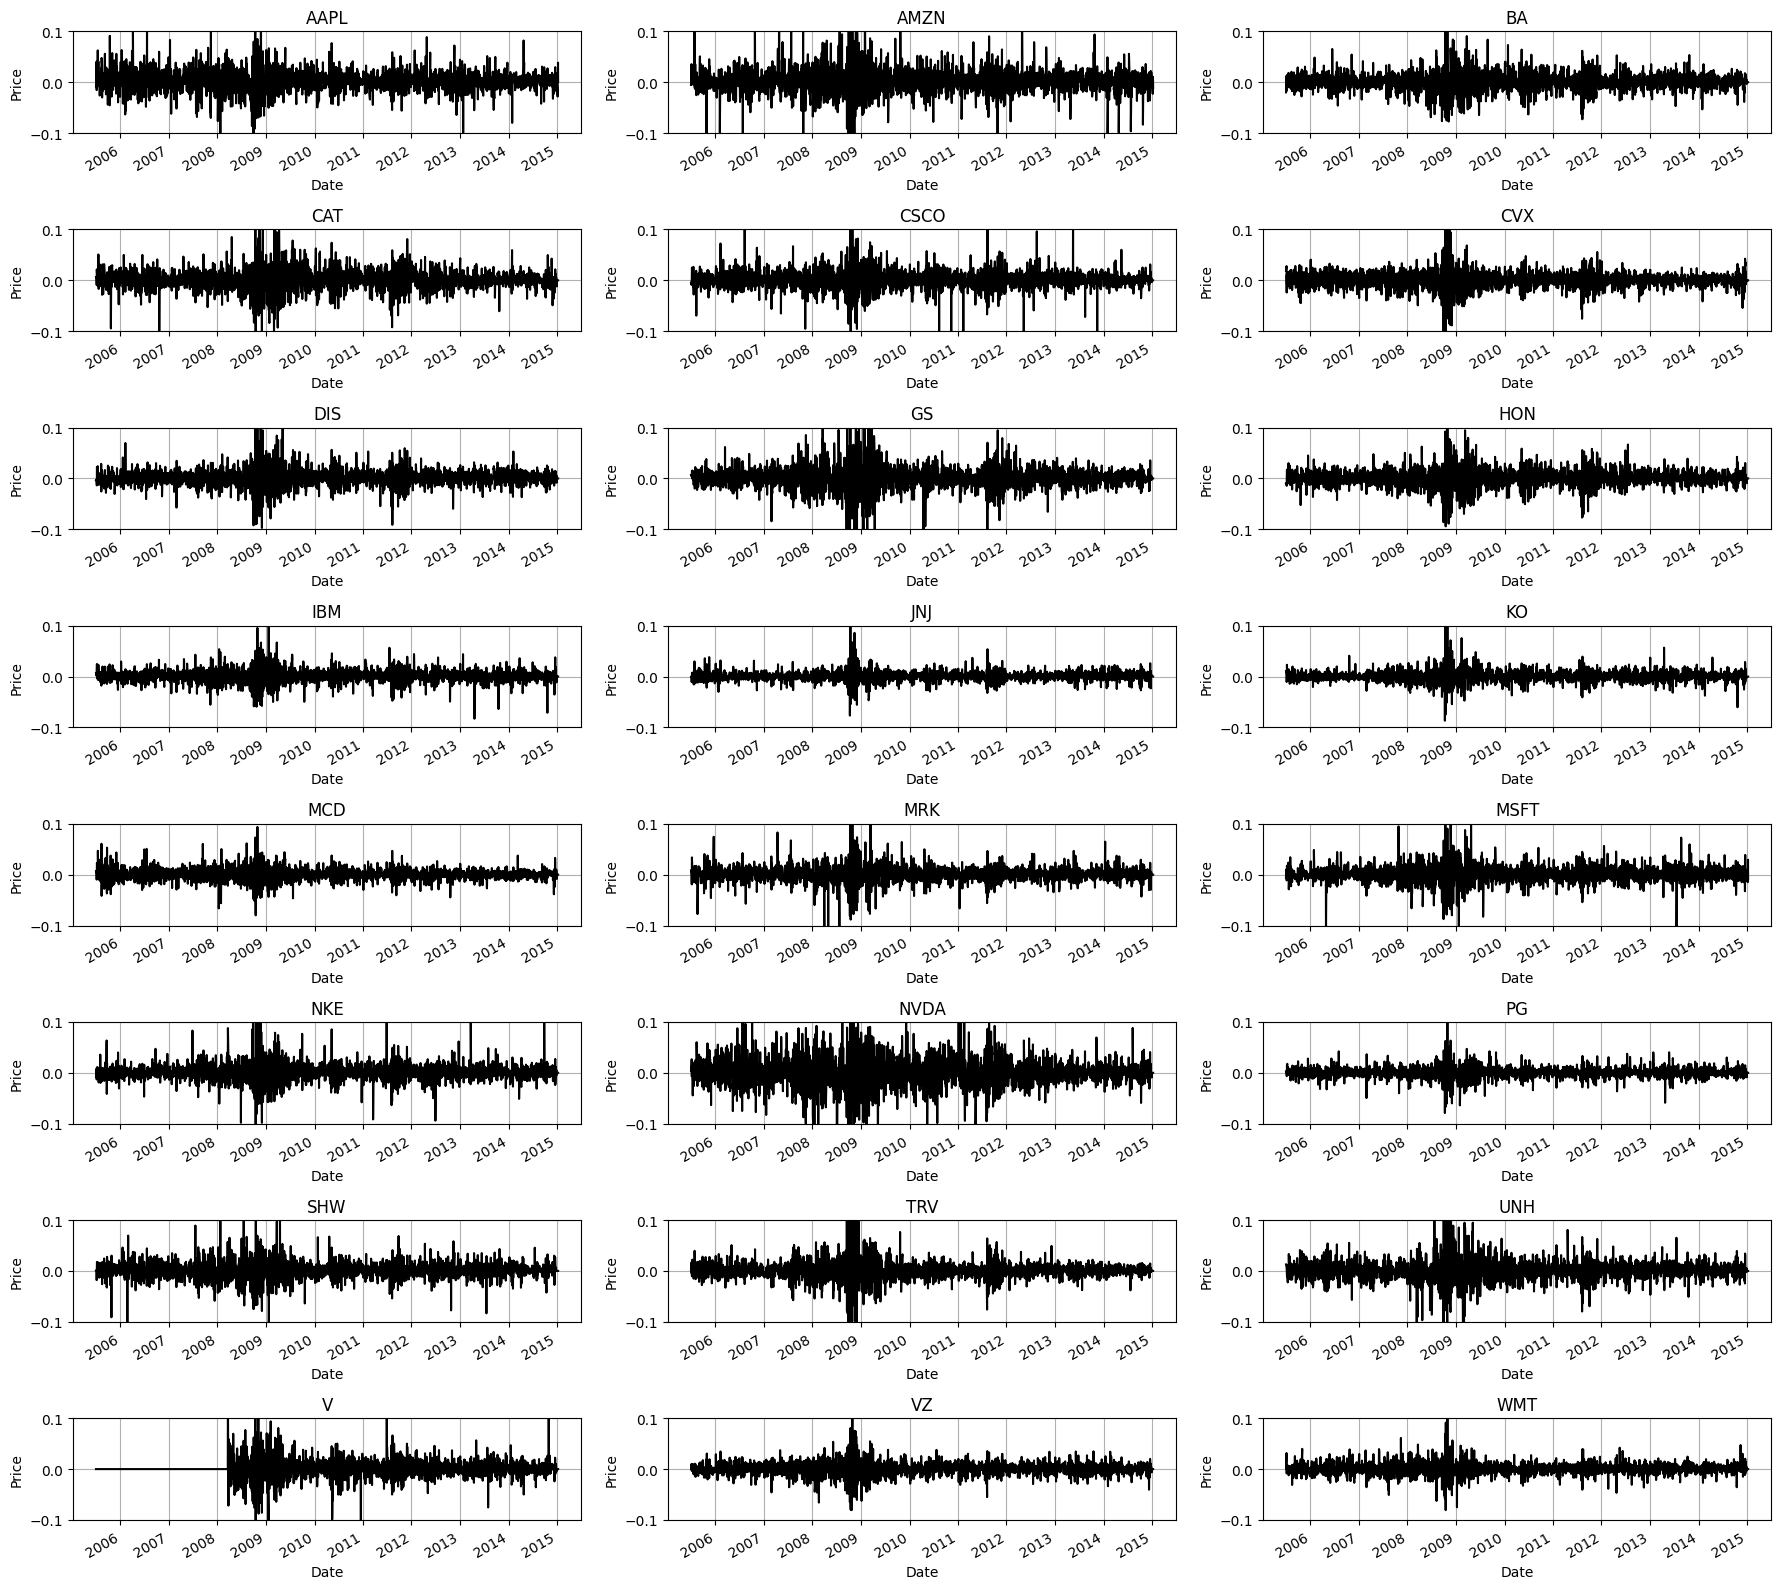

In [17]:
qf.plot_grid(returns, n_cols=3, ylim=(-0.1, 0.1), figsize=(6, 2))

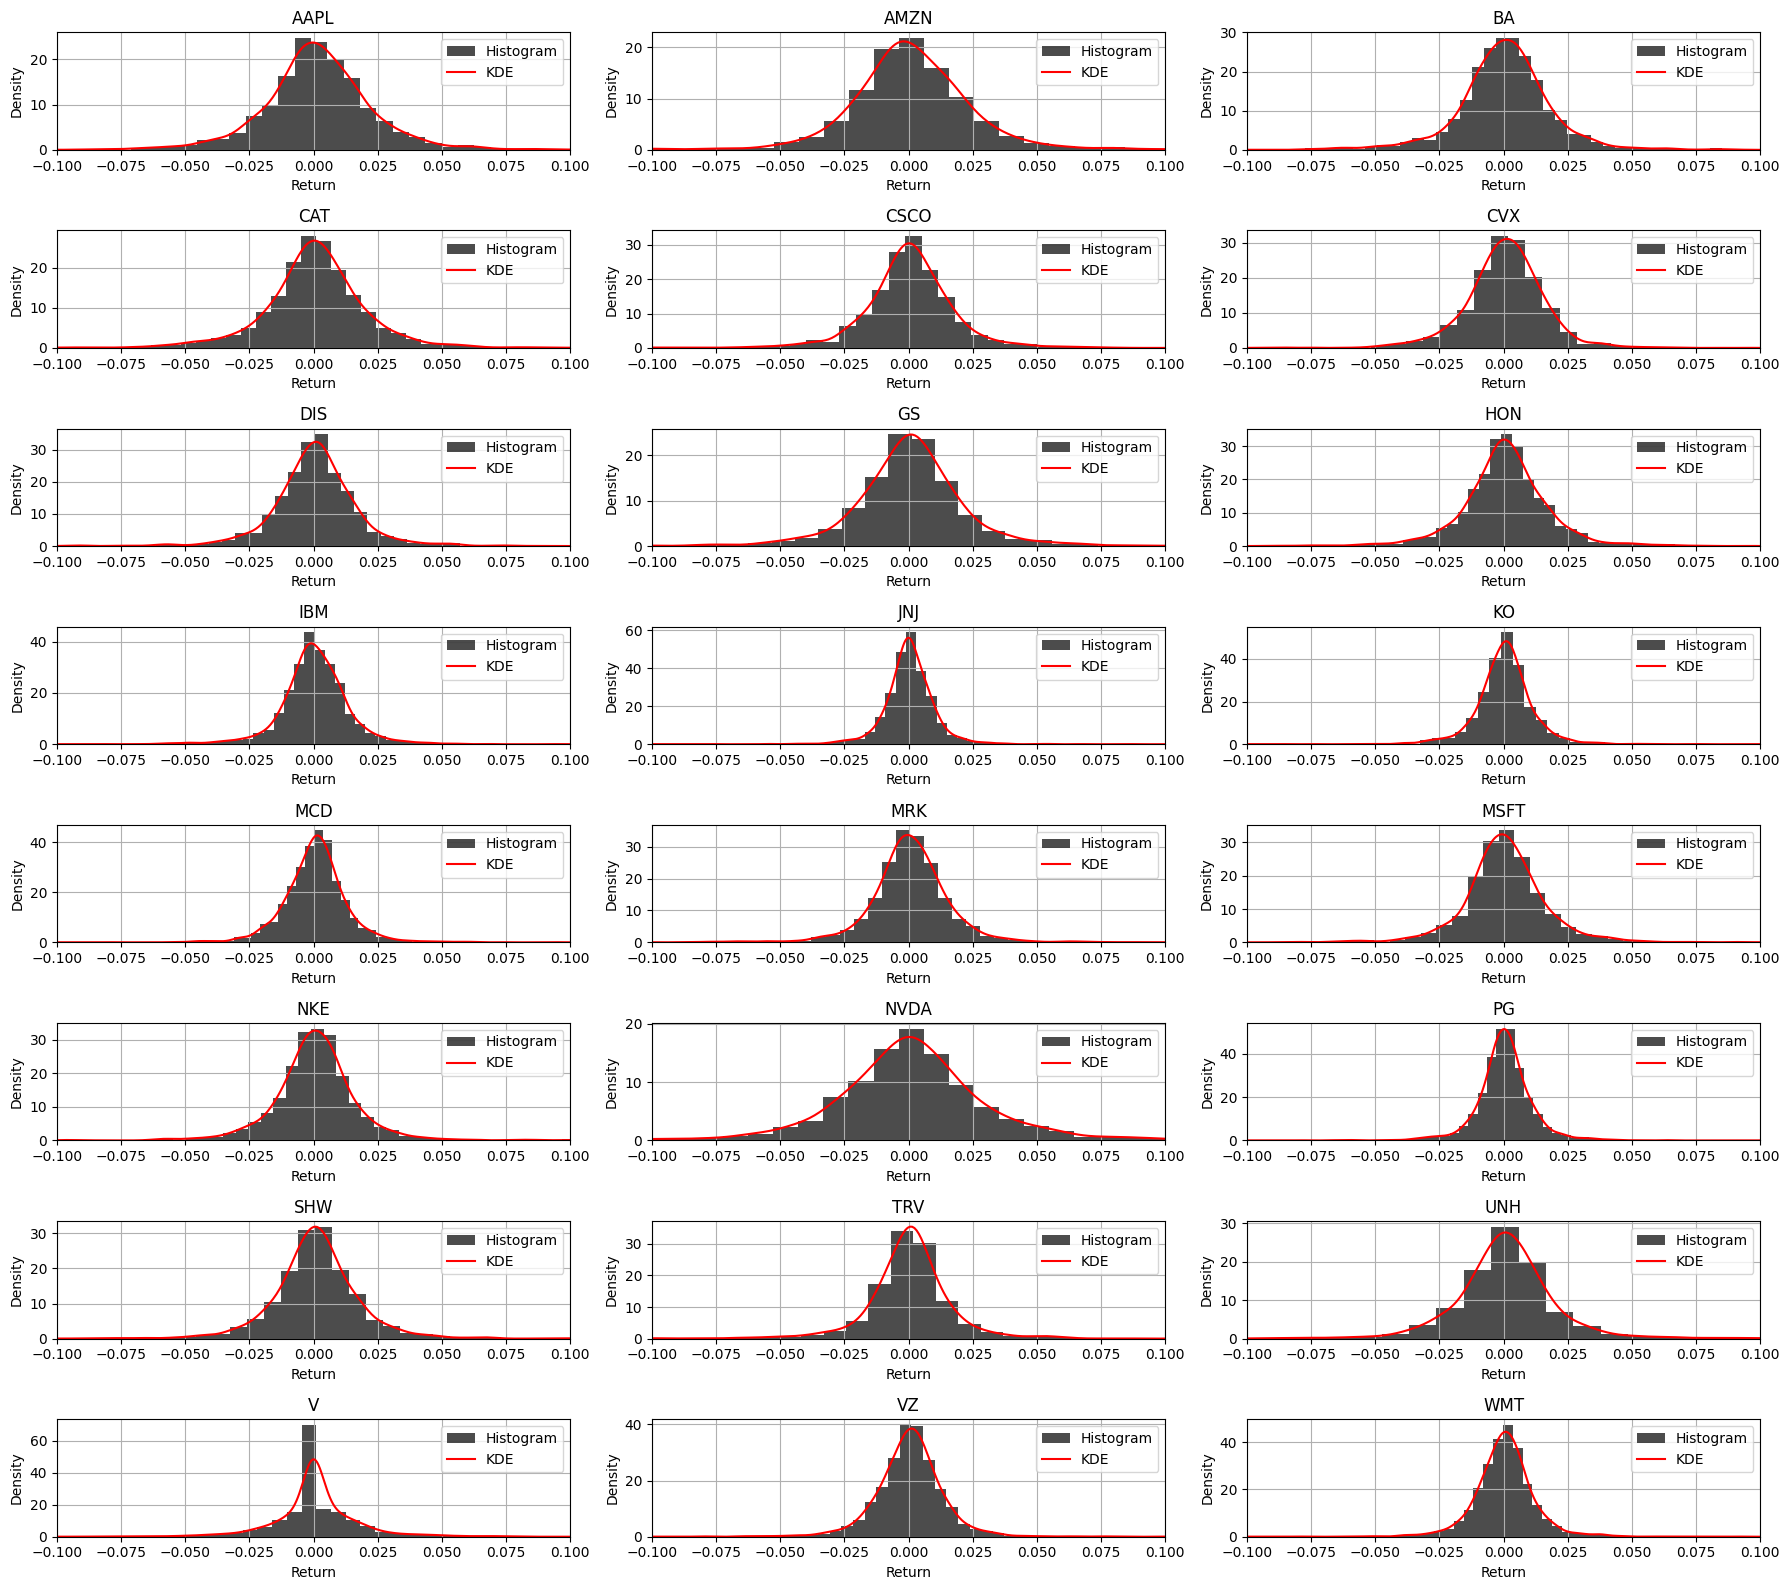

In [18]:
qf.plot_hist_grid(returns, n_cols=3, bins=50, figsize=(6, 2), log_y_scale=False)


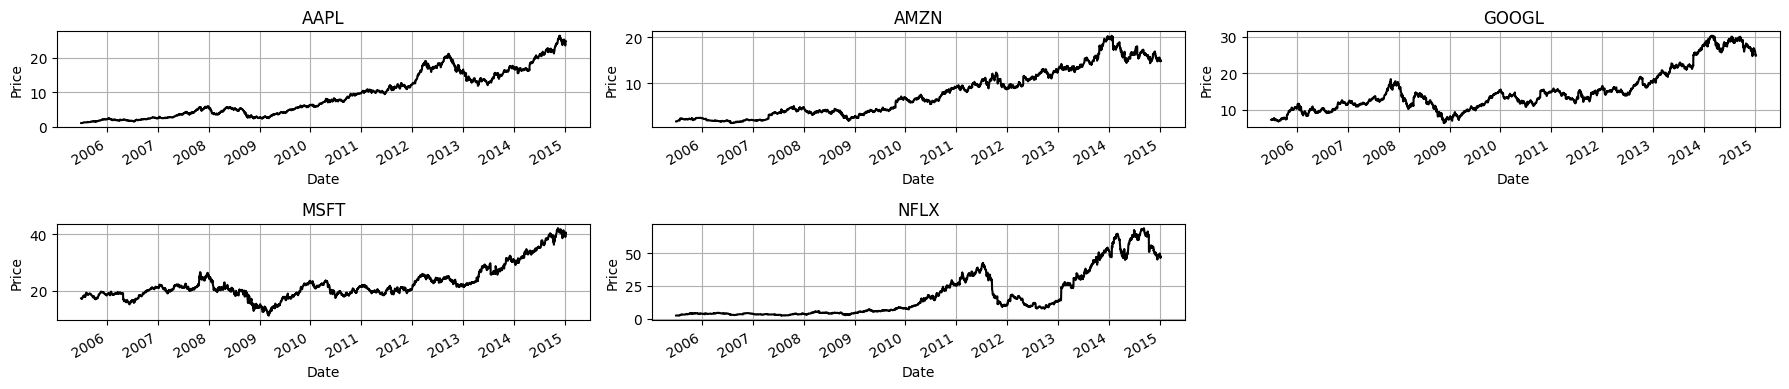

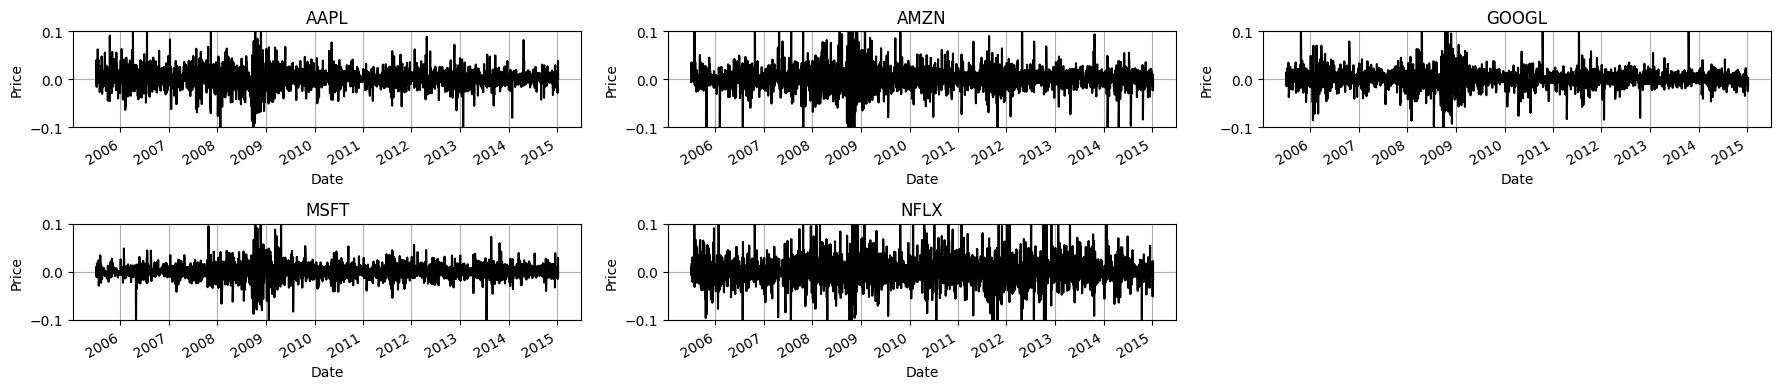

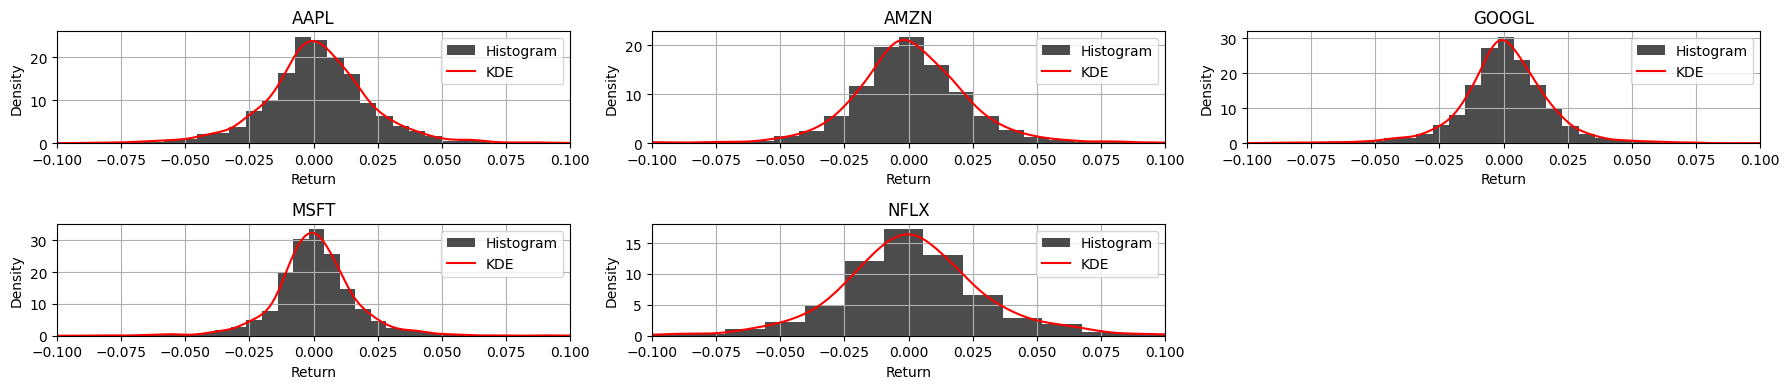

In [8]:
# Now we want to compare the statistics of the returns of the tickers if we use 
prices_bfill = qf.get_data(tickers, 
            start=qf.DEFAULT_TRAIN_START, 
            end=qf.DEFAULT_TRAIN_END, 
            indicators="close", 
            imputation_method="removal",
            n_trading_days=252)

returns_bfill = prices_bfill.pct_change().dropna()
log_returns_bfill = prices_bfill.pct_change().apply(lambda x: np.log(1 + x)).dropna()


qf.plot_grid(prices_bfill)

qf.plot_grid(returns_bfill, n_cols=3, ylim=(-0.1, 0.1), figsize=(6, 2))

qf.plot_hist_grid(returns_bfill, n_cols=3, bins=50, figsize=(6, 2), log_y_scale=False)


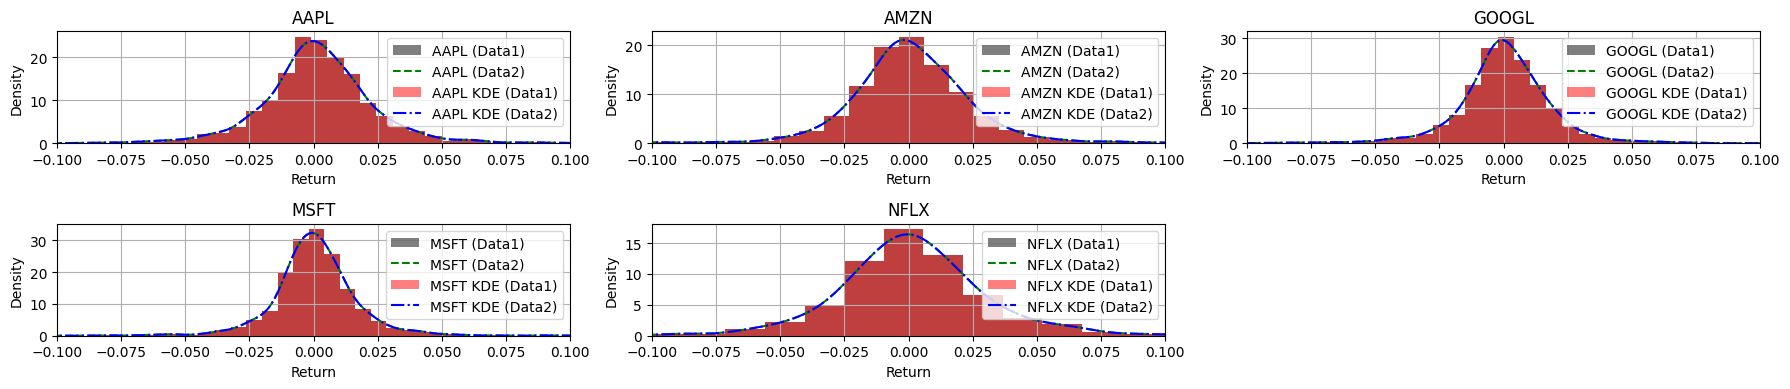

In [9]:
qf.plot_hist_grid_compare(returns, returns_bfill,
                          n_cols=3, bins=50, figsize=(6, 2))

In [10]:
# Calculate and compare the statistics of the returns
def calculate_statistics(returns):
    stats = {
        'mean': returns.mean(),
        'std': returns.std(),
        'skew': returns.skew(),
        'kurtosis': returns.kurtosis()
    }
    return stats

stats = calculate_statistics(log_returns)
stats_bfill = calculate_statistics(log_returns_bfill)

import pandas as pd

# Now stats is a dictionary of multiindex dataframes
# Make a new level in the index for the statistics
stats_df = pd.DataFrame(stats).T
stats_bfill_df = pd.DataFrame(stats_bfill).T

error = stats_df - stats_bfill_df

# Absoluter Fehler
abs_error = (stats_df - stats_bfill_df).abs()

# Relativer Fehler nur für std
rel_error_std = abs_error.loc['std'] / stats_df.loc['std']

In [11]:
abs_error

Ticker,AAPL,AMZN,GOOGL,MSFT,NFLX,TSLA
Price,Close,Close,Close,Close,Close,Close
mean,0.0,0.0,0.0,0.0,0.0,NaN
std,0.0,0.0,0.0,0.0,0.0,NaN
skew,0.0,0.0,0.0,0.0,0.0,NaN
kurtosis,0.0,0.0,0.0,0.0,0.0,NaN


In [12]:


# Bewertung
tolerable = {
    'mean': abs_error.loc['mean'] < 1e-4,
    'std': rel_error_std < 0.01,
    'skew': abs_error.loc['skew'] < 0.1,
    'kurtosis': abs_error.loc['kurtosis'] < 0.5
}

# Überblick
tolerable_df = pd.DataFrame(tolerable)
print(tolerable_df)

               mean    std   skew  kurtosis
Ticker Price                               
AAPL   Close   True   True   True      True
AMZN   Close   True   True   True      True
GOOGL  Close   True   True   True      True
MSFT   Close   True   True   True      True
NFLX   Close   True   True   True      True
TSLA   Close  False  False  False     False
